In [1]:
import tike.ptycho
import numpy as np
import matplotlib.pyplot as plt

In [2]:
for module in [tike, np]:
    print("{} is version {}".format(module.__name__, module.__version__))

numpy is version 1.12.1
tike is version 0.4.0


# Create test data

Make a test data for pytchography reconstruction at one projection angle.

### Define the object

Normalize input uint8 images to the `[0, 1]` and `[0, pi]` ranges.

In [3]:
amplitude = plt.imread("../tests/data/Cryptomeria_japonica-0128.tif") / 255
phase = plt.imread("../tests/data/Bombus_terrestris-0128.tif") / 255 * np.pi
np.min(phase), np.max(phase)

(0.036959913571644624, 3.1292726823992449)

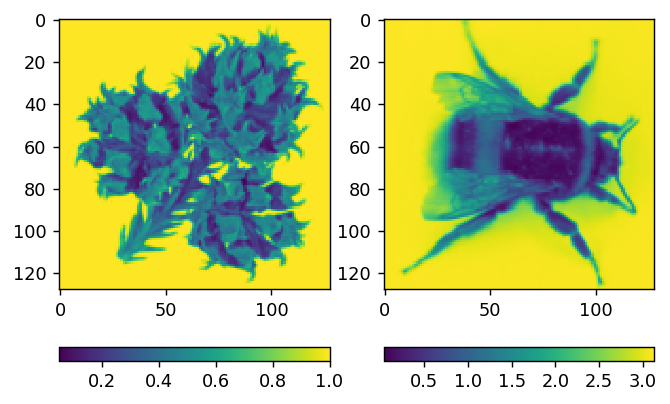

(-0.999924110115+0.0123196595352j) (0.995146916407+0.0984002782796j)


(2, 128, 128)

In [4]:
original = amplitude * np.exp(1j * phase)
original = np.tile(original, (2, 1, 1))
tike.plot_phase(original[0])
original.shape

### Define the probe

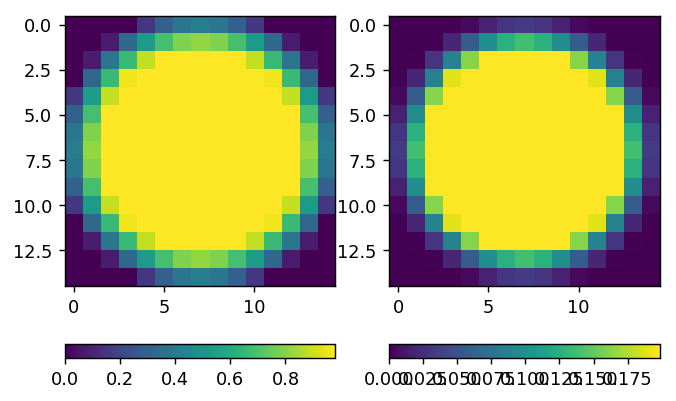

In [5]:
pw = 15 # probe width
weights = tike.ptycho.gaussian(pw, rin=0.8, rout=1.0)
probe = weights * np.exp(1j * weights * 0.2)
tike.plot_complex(probe)

### Define the trajectory

In [6]:
v, h = np.meshgrid(np.linspace(0, amplitude.shape[0]-pw, 24, endpoint=False),
                   np.linspace(0, amplitude.shape[0]-pw, 24, endpoint=False),
                   )
print(h.shape, h.size)
v = v.flatten()
h = h.flatten()

(24, 24) 576


## Simulate data acquisition

In [7]:
# Then what we see at the detector is the wave propagation
# of the near field wavefront
data = tike.ptycho.simulate(data_shape=np.ones(2, dtype=int)*pw*3,
                            probe=probe, v=v, h=h,
                            psi=original)
data.shape

(1152, 45, 45)

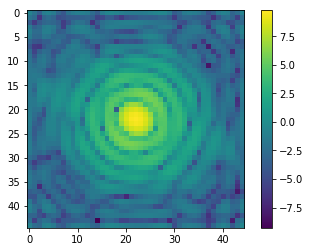

(1.3927810604125728e-07, 21374.842703371323)

In [8]:
plt.imshow(np.fft.fftshift(np.log(data[11])))
plt.colorbar()
plt.show()
np.min(data), np.max(data)

# Reconstruct

Now we need to try and reconstruct psi.

In [9]:
# Start with a guess of all zeros for psi
new_psi = np.ones(original.shape, dtype=complex)

INFO:tike.ptycho:grad on 1,152 - 45 by 45 grids for 1 iterations


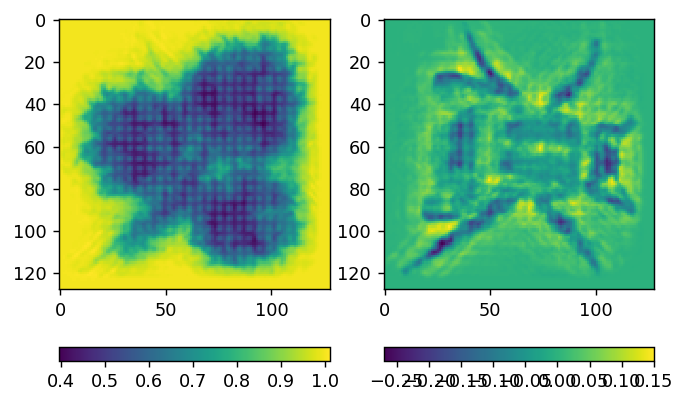

INFO:tike.ptycho:grad on 1,152 - 45 by 45 grids for 1 iterations


(0.394960193861+0.0204890290197j) (1.00995469289+0.00270110215083j)


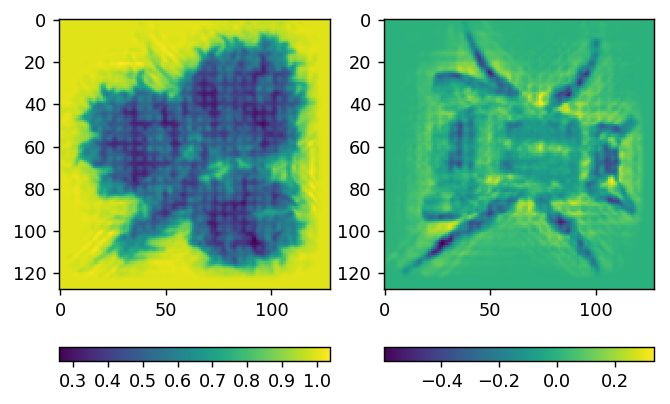

INFO:tike.ptycho:grad on 1,152 - 45 by 45 grids for 1 iterations


(0.24907631682-0.0691987392606j) (1.03112729855+0.0795333234945j)


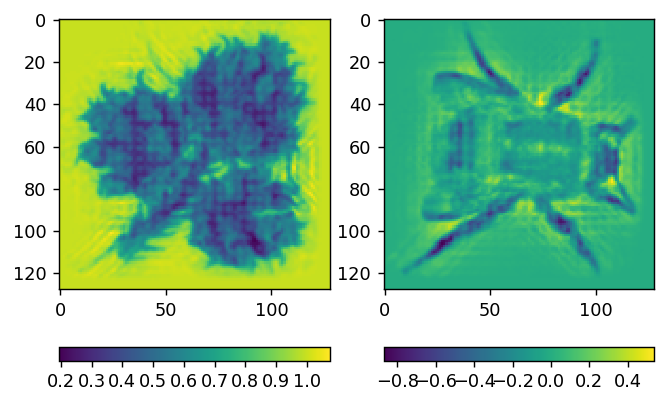

INFO:tike.ptycho:grad on 1,152 - 45 by 45 grids for 1 iterations


(0.167905079312-0.0971873842074j) (1.05233768147+0.101431457616j)


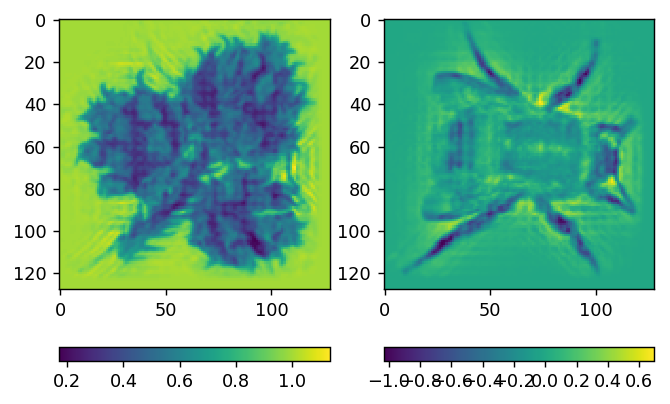

INFO:tike.ptycho:grad on 1,152 - 45 by 45 grids for 1 iterations


(0.127277917946-0.113258969947j) (1.09135359206-0.191528758012j)


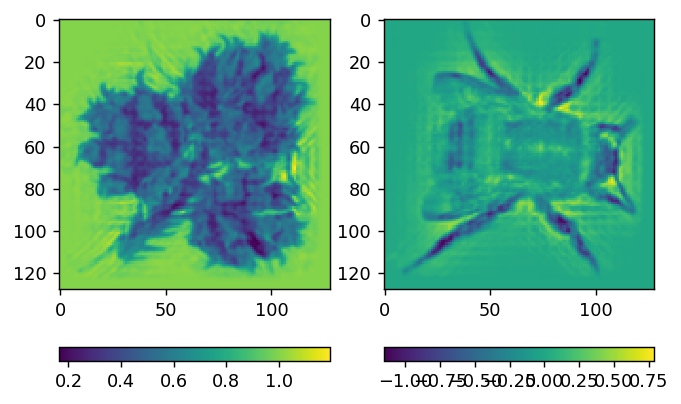

INFO:tike.ptycho:grad on 1,152 - 45 by 45 grids for 1 iterations


(0.111086088666-0.120732310002j) (1.1487303065+0.0468537385362j)


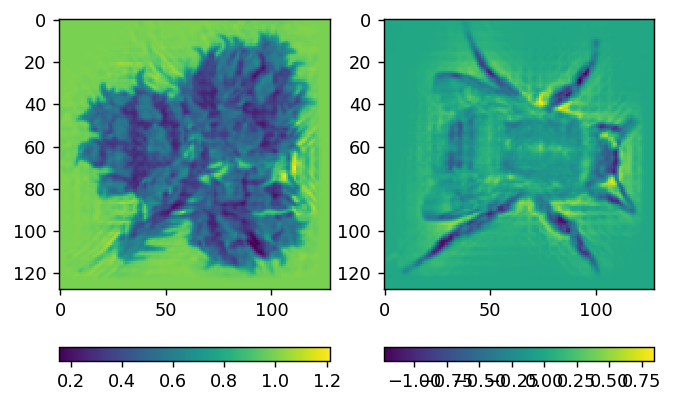

INFO:tike.ptycho:grad on 1,152 - 45 by 45 grids for 1 iterations


(0.105868355165-0.112242566651j) (1.18243130934+0.0389529454514j)


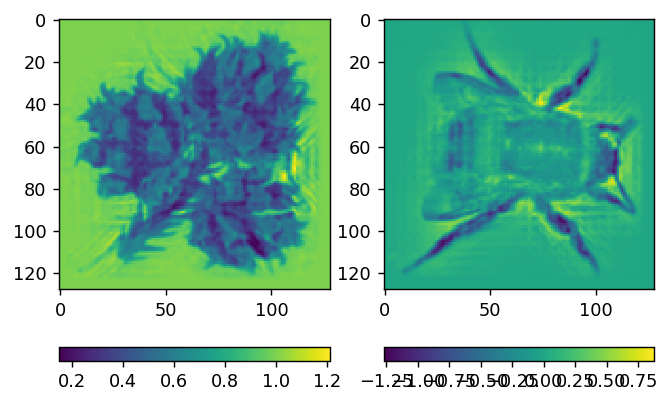

INFO:tike.ptycho:grad on 1,152 - 45 by 45 grids for 1 iterations


(0.0951751015385-0.124829495552j) (1.20096054235+0.0253806063752j)


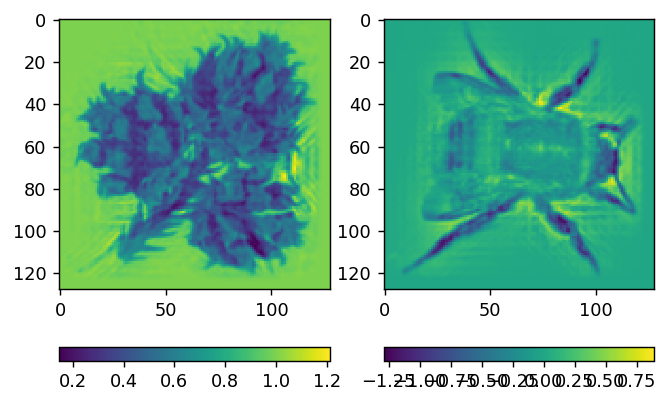

INFO:tike.ptycho:grad on 1,152 - 45 by 45 grids for 1 iterations


(0.0904156845418-0.120934727902j) (1.21067145307+0.00992601209712j)


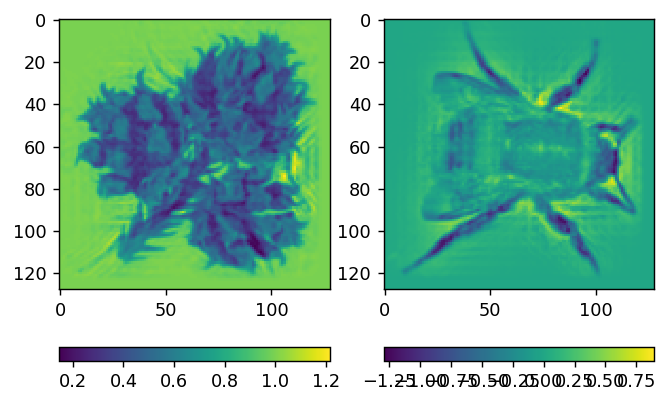

INFO:tike.ptycho:grad on 1,152 - 45 by 45 grids for 1 iterations


(0.0895120277575-0.118112242728j) (1.21438160074-0.00649714492386j)


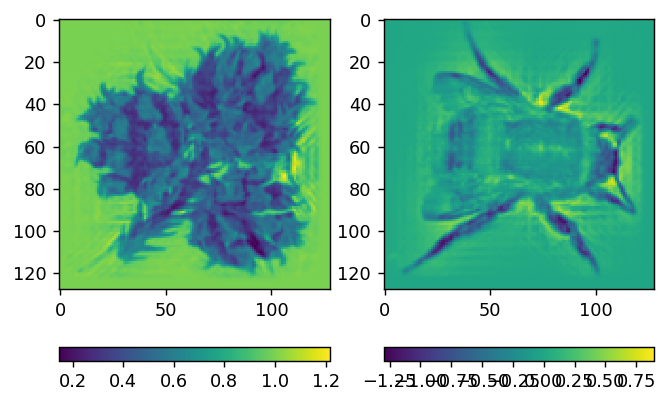

(0.0905527527585-0.116287068556j) (1.21546877969-0.0226293909749j)


In [10]:
for i in range(10):
    new_psi = tike.ptycho.reconstruct(data=data,
                                      probe=probe, v=v, h=h,
                                      psi=new_psi,
                                      algorithm='grad',
                                      niter=1, rho=0.5, gamma=0.25)
    tike.plot_phase(new_psi[0])